In [80]:
import numpy as np 
import matplotlib.pyplot as plt

# Single neuron

![experiment schematic](single_cell_recording.png "Single cell recording")
![simplified system](singe_cell_sim.svg)

This simplified model of a neuron is mathematically expressed with a first-order ordinary differential equation:

$$
\tau \frac{d r(t)}{dt} = -r(t) + I(t)
$$

which we can discretize in time (in steps $dt$) in order to simulate numerically using the Euler method:

$\tau \frac{r(t+dt) - r(t)}{dt} = -r(t) + I(t) \; \; \; $ so that:  $\; \; \; r(t+dt) = r(t) + \frac{dt}{\tau} \left[ -r(t) + I(t) \right]$

Here is a piece of code that simulates how a neuron with membrane time constant $\tau$ integrates a time varying input and generates a rate output $r(t)$

In [81]:
dt = 0.01
time = np.arange(0, 5, dt)
Nt = len(time)

T = 0.5
input = 1 + np.sin(2*np.pi*time/T)

rate = np.ones((Nt,))

tau = 0.02
for i in range(Nt-1):
    rate[i+1] = rate[i] + dt/tau*(-rate[i] + input[i])

Text(0, 0.5, 'rate')

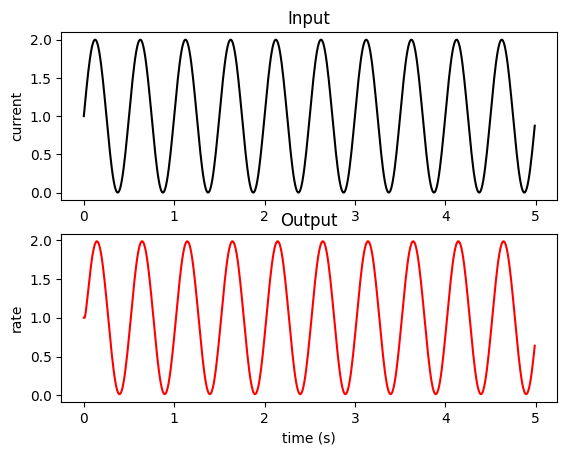

In [82]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(time, input, 'k')
ax[0].set_title('Input')
ax[0].set_ylabel('current')
ax[1].plot(time, rate, 'r')
ax[1].set_title('Output')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('rate')


Now copy the code above to see how a neuron with a much longer time constant (e.g. $\tau = 1 s$) would integrate this same input:

Now compare again the two neurons, one with short time constant ($\tau = 0.02 s$) and one with very long time constant ($\tau = 10 s$), but now have them respond to an input representing a current pulse, as per the code below:

In [83]:
input = np.ones((Nt,))
pulsesat = int(Nt/6)
input[pulsesat] = 3


Text(0, 0.5, 'rate')

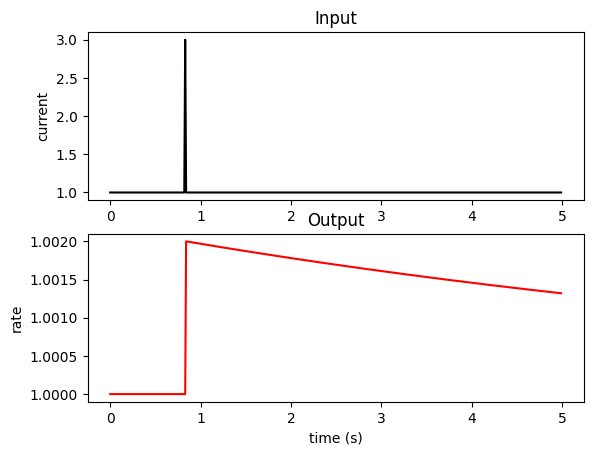

In [84]:
rate = np.ones((Nt,))

tau = 10
for i in range(Nt-1):
    rate[i+1] = rate[i] + dt/tau*(-rate[i] + input[i])

fig, ax = plt.subplots(nrows=2)
ax[0].plot(time, input, 'k')
ax[0].set_title('Input')
ax[0].set_ylabel('current')
ax[1].plot(time, rate, 'r')
ax[1].set_title('Output')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('rate')

What do you see?

Now do the same thing but for an input consisting in a train of successive current pulses:

In [85]:
input = np.ones((Nt,))
pulsesat = int(Nt/6)*np.array([1,2,3,4,5])
input[pulsesat] = 3

Text(0, 0.5, 'rate')

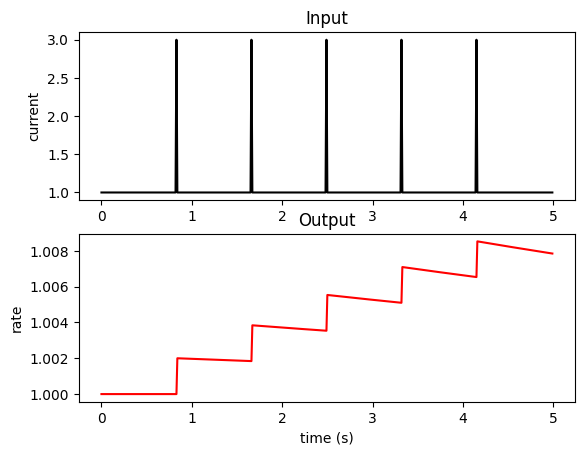

In [86]:
rate = np.ones((Nt,))

tau = 10
for i in range(Nt-1):
    rate[i+1] = rate[i] + dt/tau*(-rate[i] + input[i])

fig, ax = plt.subplots(nrows=2)
ax[0].plot(time, input, 'k')
ax[0].set_title('Input')
ax[0].set_ylabel('current')
ax[1].plot(time, rate, 'r')
ax[1].set_title('Output')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('rate')

This is quite exciting: a single neuron can do things such as memory, or stimulus counting (integration)... but, what is a realistic membrane time constant in the brain? 20ms!

How could the brain do memory or stimulus integration if neurons have such slow time constant? Networks! Here is the simplest possible network:

# Neuron with autapse

![Autapse](autapse.svg "Autapse")

Now this simplified network model of a neuron is mathematically expressed with this first-order ordinary differential equation:

$$
\tau \frac{d r(t)}{dt} = -r(t) + \alpha r(t) + I(t)
$$

where $\alpha$ is the strength of the self-coupling of the neuron with itself (autapse). We again discretize this equation in time (in steps $dt$) using the Euler method to get:

$r(t+dt) = r(t) + \frac{dt}{\tau} \left[ (\alpha - 1) r(t) + I(t) \right]$

Now try simulating this equation for various values of $\alpha$ (restricted to be non-negative, $\alpha \ge 0$) when the neuron has a short membrane time constant (keep fixed $\tau = 0.02s$):

Text(0, 0.5, 'rate')

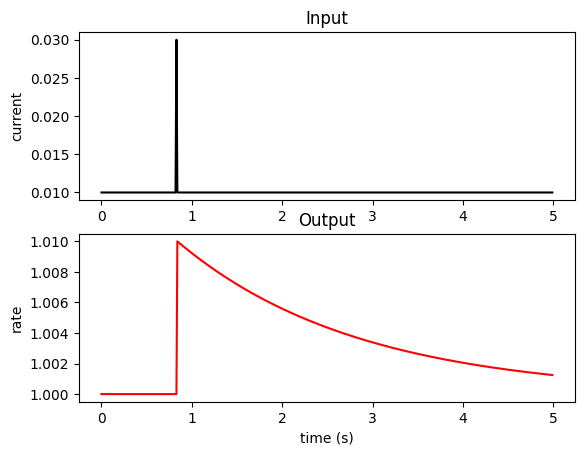

In [87]:
input = np.ones((Nt,))
pulsesat = int(Nt/6)
input[pulsesat] = 3

rate = np.ones((Nt,))

tau = 0.02
alpha = 0.99

input = input*np.abs(1-alpha)
for i in range(Nt-1):
    rate[i+1] = rate[i] + dt/tau*((alpha - 1)*rate[i] + input[i])

fig, ax = plt.subplots(nrows=2)
ax[0].plot(time, input, 'k')
ax[0].set_title('Input')
ax[0].set_ylabel('current')
ax[1].plot(time, rate, 'r')
ax[1].set_title('Output')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('rate')

In what conditions does this network show perfect memory (i.e. it has a different rate depending on whether a stimulus was presented in the past or not)?

What happens if you set $\alpha>1$?

So, through recurrent connections, neurons with short membrane time constants can achieve memory and integration capabilities as if they had long time constants. This is one of the fundamental principles of network function in attractor networks.

Now let's address the issues with this simple network function: fine-tuning of memory ($\alpha=1$) and instabilities when $\alpha > 1$. Let us consider a fundamental architectural motif in neural circuits in the cerebral cortex: neurons are either excitatory or inhibitory, and are strongly coupled with one another. 

# The E-I circuit

![](EInetwork.svg)

We thus consider two neurons, one excitatory, one inhibitory, mutually connected. The network model is now mathematically expressed with this system of coupled first-order ordinary differential equations:

$$
\tau \frac{d r_E(t)}{dt} = -r_E(t) + \left[ W_{EE} r_E(t) - W_{EI} r_I(t) + I_E(t) - \theta_E \right]_{+} \\
\tau \frac{d r_I(t)}{dt} = -r_I(t) + \left[ W_{IE} r_E(t) - W_{II} r_I(t) + I_I(t) - \theta_I \right]_{+} 
$$

where $W_{XY}$ are all non-negative and denote the strengths of the couplings between neuron $X$ and neuron $Y$. To ensure that firing rates are positive, we apply a linear-threshold transformation $[\;I - \theta ]_{+}$ to the inputs, with thresholds $\theta_E$ and $\theta_I$. We again discretize this equation in time (in steps $dt$) using the Euler method to get:

$$
r_E(t+dt) = r_E(t) + \frac{dt}{\tau} \left( -r_E(t) + \left[ W_{EE} r_E(t) - W_{EI} r_I(t) + I_E(t) - \theta_E \right]_+ \right)\\
r_I(t+dt) = r_I(t) + \frac{dt}{\tau} \left( -r_I(t) + \left[ W_{IE} r_E(t) -W_{II} r_I(t) + I_I(t) - \theta_I \right]_+ \right)
$$

This system now is quite rich and can display a number of interesting dynamics. For instance, it can show the memory function that we discussed, but in a much more robust system. You can play with connectivity strengths in this code and convince you that this perfect memory is not subject to strict fine-tuning, thanks to the interaction of excitation and inhibition. For a detailed analysis of this system dynamics, you can explore [this article ](https://doi.org/10.7554/eLife.22425).

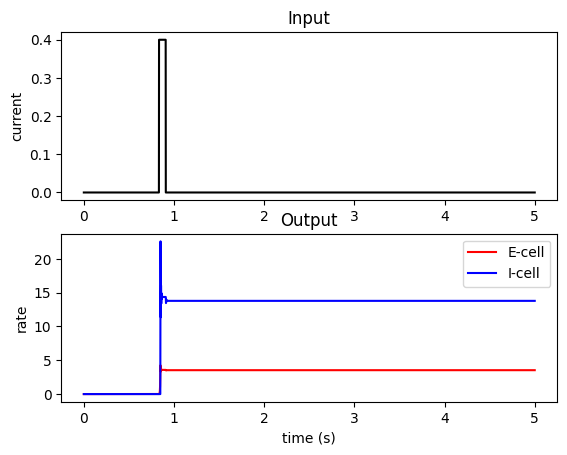

In [88]:
dt = 0.0005
time = np.arange(0, 5, dt)
Nt = len(time)

input = np.zeros((Nt,))
pulsesat = int(Nt/6)
input[pulsesat:pulsesat+150] = 0.4

tauE = 0.01
tauI = 0.002
WEE = 5
WEI = 1
WIE = 10
WII = 0.5
GE = 1
GI = 4

rateI = np.zeros((Nt,))
rateE = np.zeros((Nt,))

def rectify(x, threshold):
    return (x - threshold) * (x > threshold)

for i in range(Nt-1):
    rateE[i+1] = rateE[i] + dt/tauE*( -rateE[i] + GE * rectify(WEE*rateE[i] - WEI*rateI[i] + input[i], 0.35) )
    rateI[i+1] = rateI[i] + dt/tauI*( -rateI[i] + GI * rectify(WIE*rateE[i] - WII*rateI[i] , 25) )

fig, ax = plt.subplots(nrows=2)
ax[0].plot(time, input, 'k')
ax[0].set_title('Input')
ax[0].set_ylabel('current')
ax[1].plot(time, rateE, 'r', label='E-cell')
ax[1].plot(time, rateI, 'b', label='I-cell')
ax[1].set_title('Output')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('rate')
ax[1].legend()

How does this network respond to an excitatory input pulse applied to the excitatory population? and to the inhibitory population? 

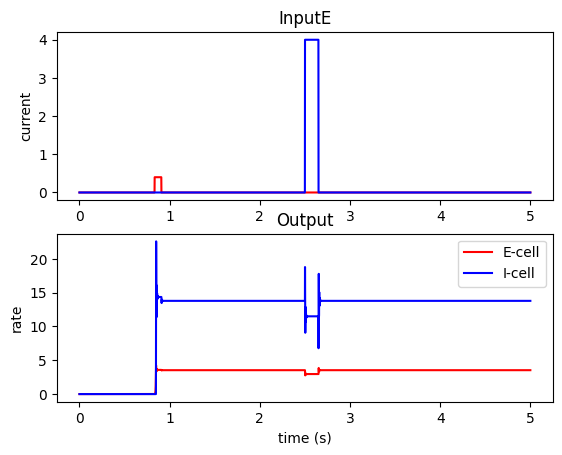

In [89]:
dt = 0.0005
time = np.arange(0, 5, dt)
Nt = len(time)

# initialize all inputs to zero
inputE = np.zeros((Nt,))
inputI = np.zeros((Nt,))

# first pulse to go into the non-zero solution
pulsesat = int(Nt/6)
inputE[pulsesat:pulsesat+150] = 0.4 

# now let's apply a pulse in the middle of the simulation to either the excitatory or the inhibitory neuron
pulsesat = int(3*Nt/6)
inputI[pulsesat:pulsesat+300] = 4
#inputE[pulsesat:pulsesat+300] = 4

tauE = 0.01
tauI = 0.002
WEE = 5
WEI = 1
WIE = 10
WII = 0.5
GE = 1
GI = 4

rateI = np.zeros((Nt,))
rateE = np.zeros((Nt,))

def rectify(x, threshold):
    return (x - threshold) * (x > threshold)

for i in range(Nt-1):
    rateE[i+1] = rateE[i] + dt/tauE*( -rateE[i] + GE * rectify(WEE*rateE[i] - WEI*rateI[i] + inputE[i], 0.35) )
    rateI[i+1] = rateI[i] + dt/tauI*( -rateI[i] + GI * rectify(WIE*rateE[i] - WII*rateI[i] + inputI[i], 25) )

fig, ax = plt.subplots(nrows=2)
ax[0].plot(time, inputE, 'r')
ax[0].plot(time, inputI, 'b')
ax[0].set_title('InputE')
ax[0].set_ylabel('current')
ax[1].plot(time, rateE, 'r', label='E-cell')
ax[1].plot(time, rateI, 'b', label='I-cell')
ax[1].set_title('Output')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('rate')
ax[1].legend()

What do you see? Do you see a paradox? This network regime has been named "inhibition-stabilized network" or ISN. You can learn more about it in [this article](https://doi.org/10.1016/j.neuron.2009.03.028). This regime of operation is now considered to apply quite generally to neural circuits in the cerebral cortex (see [this article](https://doi.org/10.7554/eLife.54875)).

# Double-well attractor

![](doublewell.svg)

Now this starts getting complicated. Following the previous schematic for the EI network above, enter below the simulation for this 3-neuron network (in practice, we think of each unit in the network as a population of neurons, so we talk of a 3-population network):

However, we usually simplify things to deal with only two dynamical variables. Here, we can take advantage of the fact that inhibitory neurons have a faster time constant to assume that their equation relaxes more quickly to the steady state, so we freeze the firing rate of the inhibitory population to the steady state of its dynamics given the momentary rates of the two excitatory populations. If you are interested in these derivations, you can check them in [this book chapter](https://neuronaldynamics.epfl.ch/online/Ch16.S3.html). The resulting equations are:

$$
\tau_E \frac{d I_{E,1}}{dt} = - I_{E1} + (W_{EE} - \alpha) g_E(I_{E1}) - \alpha g_E(I_{E2}) + S_{1} \\
\tau_E \frac{d I_{E,2}}{dt} = - I_{E2} + (W_{EE} - \alpha) g_E(I_{E2}) - \alpha g_E(I_{E1}) + S_{2} 
$$

where $\alpha = -\gamma W_{EI}W_{IE}$ represents the effective inhibitory coupling between excitatory populations (via the inhibitory population), and $S_1$/$S_2$ are the inputs arriving to each excitatory population. Note that this model formulation is slightly different to what we have been doing so far in this workshop: now our dynamical variables are the inputs and not the rates of the populations. To plot the rates, we have to use $r_{E} = g_E(I_E)$.

These equations can be discretized to obtain this simulation code:

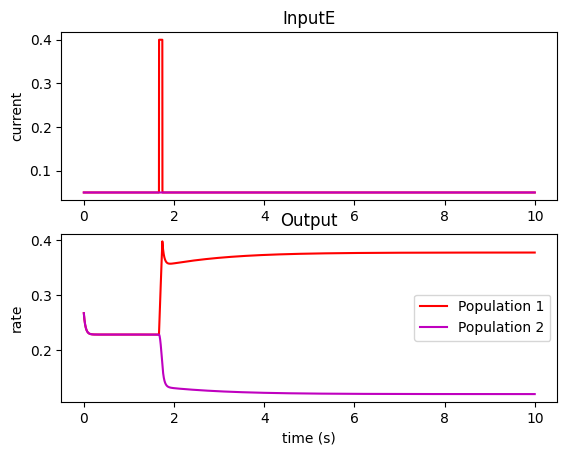

In [90]:
dt = 0.0005
time = np.arange(0, 10, dt)
Nt = len(time)

# initialize inputs 
drive0 = 0.05
inputE1 = drive0*np.ones((Nt,))
inputE2 = drive0*np.ones((Nt,))


# current pulse into one of the two populations
pulsesat = int(Nt/6)
inputE1[pulsesat:pulsesat+150] = 0.4 


tauE = 0.05
WEE = 2.9
WEI = -1
WIE = 1
gamma = 1.8

alpha = -gamma * WEI * WIE

inpE1 = -0.005*np.ones((Nt,))
inpE2 = -0.005*np.ones((Nt,))

def curr_to_rate(x):
    return (1+np.tanh(x-0.5))/2

for i in range(Nt-1):
    inpE1[i+1] = inpE1[i] + dt/tauE*(-inpE1[i] + (WEE - alpha)*curr_to_rate(inpE1[i]) - alpha*curr_to_rate(inpE2[i]) + inputE1[i] )
    inpE2[i+1] = inpE2[i] + dt/tauE*(-inpE2[i] + (WEE - alpha)*curr_to_rate(inpE2[i]) - alpha*curr_to_rate(inpE1[i]) + inputE2[i] )

rateE1 = curr_to_rate(inpE1)
rateE2 = curr_to_rate(inpE2)

fig, ax = plt.subplots(nrows=2)
ax[0].plot(time, inputE1, 'r')
ax[0].plot(time, inputE2, 'm')
ax[0].set_title('InputE')
ax[0].set_ylabel('current')
ax[1].plot(time, rateE1, 'r', label='Population 1')
ax[1].plot(time, rateE2, 'm', label='Population 2')
ax[1].set_title('Output')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('rate')
ax[1].legend()

What happens if you send the input current pulse to population 2 instead of population 1? Argue about how this model can be used to remember specific events that happened in the recent past. 

These discrete attractor models have been applied to model working memory for objects. In this case there are just two possible memories, because there are two populations, but this can be generalized to an arbitrary number of discrete memories. If you want to learn more about these models, you can check [this paper](https://www.nature.com/articles/s41586-019-0919-7) on experimental evidence supporting it.

Also, notice how this network now responds to input by establishing a competition between the two populations: if one wins, the other one loses. This is what we call "winner-take-all" dynamics and it is thought also to be a mechanism underlying multiple brain computations from sensory perception to decision making.

### The double-well model in decision making

Now let's explore this network in a different situation: we do not establish a difference between the external inputs to the two populations but we add random independent noise to the currents of the two populations at each time step in the simulated dynamics. This represents internal noise of the brain. Explore what happens in this simulation by running it repeatedly over several "trials". Notice also that we change the overall drive to the network during the simulation, but keeping it equal for the two populations. What does this change in external drive achieve?

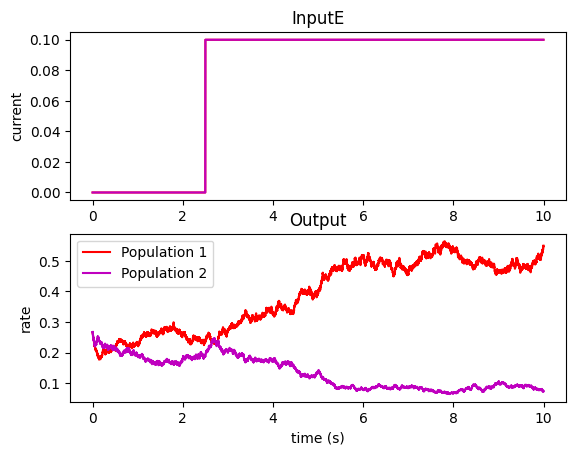

In [91]:
dt = 0.0005
time = np.arange(0, 10, dt)
Nt = len(time)

# initialize inputs 
drive0 = 0.
inputE1 = drive0*np.ones((Nt,))
inputE2 = drive0*np.ones((Nt,))

drive = 0.1
inputE1[Nt//4:] = drive
inputE2[Nt//4:] = drive

# first pulse to go into the non-zero solution
pulsesat = int(Nt/6)
#inputE1[pulsesat:pulsesat+150] = 0.4 


tauE = 0.05
WEE = 2.9
WEI = -1
WIE = 1
gamma = 1.8

alpha = -gamma * WEI * WIE

inpE1 = -0.005*np.ones((Nt,))
inpE2 = -0.005*np.ones((Nt,))

def curr_to_rate(x):
    return (1+np.tanh(x-0.5))/2

sigma = 0.3

for i in range(Nt-1):
    noise = sigma * np.random.randn()
    inpE1[i+1] = inpE1[i] + dt/tauE*(-inpE1[i] + (WEE - alpha)*curr_to_rate(inpE1[i]) - alpha*curr_to_rate(inpE2[i]) + inputE1[i] + noise)
    noise = sigma * np.random.randn()
    inpE2[i+1] = inpE2[i] + dt/tauE*(-inpE2[i] + (WEE - alpha)*curr_to_rate(inpE2[i]) - alpha*curr_to_rate(inpE1[i]) + inputE2[i] + noise)

rateE1 = curr_to_rate(inpE1)
rateE2 = curr_to_rate(inpE2)

fig, ax = plt.subplots(nrows=2)
ax[0].plot(time, inputE1, 'r')
ax[0].plot(time, inputE2, 'm')
ax[0].set_title('InputE')
ax[0].set_ylabel('current')
ax[1].plot(time, rateE1, 'r', label='Population 1')
ax[1].plot(time, rateE2, 'm', label='Population 2')
ax[1].set_title('Output')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('rate')
ax[1].legend()

Which of the two populations wins now the competition? How is that determined?

The advantage of having just two dynamical variables is that we can visualize the dynamics in what we call "phase space":

Text(0, 0.5, 'rate population 1')

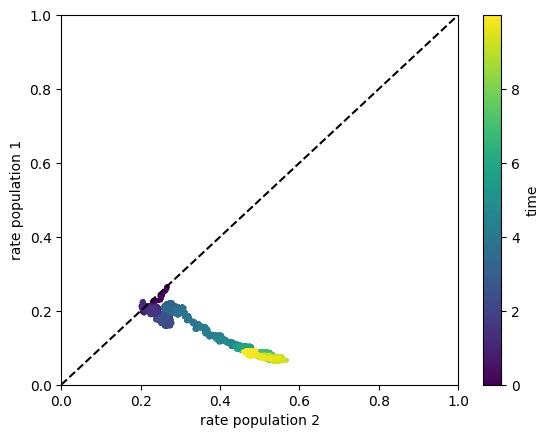

In [92]:
dt = 0.0005
time = np.arange(0, 10, dt)
Nt = len(time)

# initialize inputs 
drive0 = 0.
inputE1 = drive0*np.ones((Nt,))
inputE2 = drive0*np.ones((Nt,))

drive = 0.1
inputE1[Nt//4:] = drive
inputE2[Nt//4:] = drive

# first pulse to go into the non-zero solution
pulsesat = int(Nt/6)
#inputE1[pulsesat:pulsesat+150] = 0.4 


tauE = 0.05
WEE = 2.9
WEI = -1
WIE = 1
gamma = 1.8

alpha = -gamma * WEI * WIE

inpE1 = -0.005*np.ones((Nt,))
inpE2 = -0.005*np.ones((Nt,))

def curr_to_rate(x):
    return (1+np.tanh(x-0.5))/2

sigma = 0.3

for i in range(Nt-1):
    noise = sigma * np.random.randn()
    inpE1[i+1] = inpE1[i] + dt/tauE*(-inpE1[i] + (WEE - alpha)*curr_to_rate(inpE1[i]) - alpha*curr_to_rate(inpE2[i]) + inputE1[i] + noise)
    noise = sigma * np.random.randn()
    inpE2[i+1] = inpE2[i] + dt/tauE*(-inpE2[i] + (WEE - alpha)*curr_to_rate(inpE2[i]) - alpha*curr_to_rate(inpE1[i]) + inputE2[i] + noise)

rateE1 = curr_to_rate(inpE1)
rateE2 = curr_to_rate(inpE2)

plt.scatter(rateE1, rateE2, c=time, s=4)
plt.colorbar(label='time')
plt.xlim([0,1])
plt.ylim([0,1])
plt.axline((1, 1), slope=1, color='k', ls='--')
plt.xlabel('rate population 2')
plt.ylabel('rate population 1')

try running several times the previous cell and see how the network dynamics changes from trial to trial. Can you make sense of this dynamics? Where does the network start and where does it evolve to towards the end of the trial?

One very useful way to think about this dynamics is to visualize it as the evolution of a ball that bounces down in a hilly landscape. This is more than just a visual analogy for networks that satisfy perfect symmetry (i.e. the connection from population X to population Y is the same as the connection from population Y to population X). For these kinds of networks this analogy is mathematically exact (see for example an explanation [here](https://neuronaldynamics.epfl.ch/online/Ch16.S4.html)) and this hilly landscape is what we call "energy". See here the energy calculated for the network above:

/tmp/ipykernel_11966/2941000254.py:5: RuntimeWarning: divide by zero encountered in arctanh
  return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)
/tmp/ipykernel_11966/2941000254.py:5: RuntimeWarning: divide by zero encountered in log
  return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)
/tmp/ipykernel_11966/2941000254.py:5: RuntimeWarning: invalid value encountered in scalar add
  return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)


Text(0, 0.5, 'rate population 1')

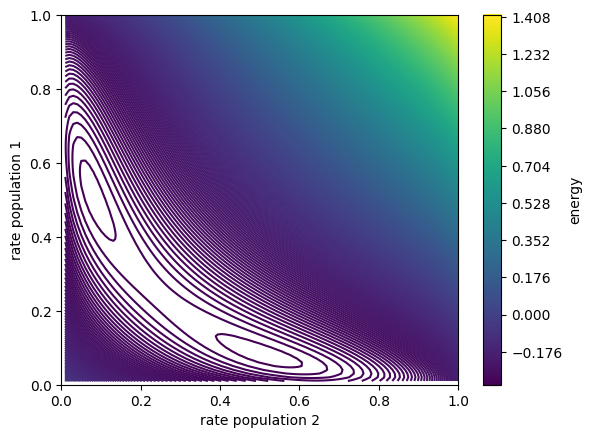

In [93]:
energy = np.zeros((100,100))

def integral(rate):
    lim = 2*rate - 1
    return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)

for i in range(100):
    r1 = i/100
    for j in range(100):
        r2 = j/100
        energy[i,j] = -0.5*(WEE - alpha)*(r1**2 + r2**2) + alpha*r1*r2 - (drive*r1 + drive*r2) + integral(r1) + integral(r2)

plt.contour(energy, extent=[0, 1, 0, 1], levels=500)
plt.colorbar(label='energy')
plt.xlabel('rate population 2')
plt.ylabel('rate population 1')

As you can see, the trajectories in phase space that we saw before are falling down this landscape towards the two "wells" of minimal energy. Based on this energy picture, we often call this dynamics "double-well attractor", and it is a possible circuit mechanism both for working memory and decision making.

Now, remember that in our dynamical simulation we changed the external drive to the simulation and that started the decision process of the network. As an exercise, visualize the energy landscape for the external drive condition at the start of the simulation. Does it make sense to you? 

/tmp/ipykernel_11966/3347669416.py:5: RuntimeWarning: divide by zero encountered in arctanh
  return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)
/tmp/ipykernel_11966/3347669416.py:5: RuntimeWarning: divide by zero encountered in log
  return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)
/tmp/ipykernel_11966/3347669416.py:5: RuntimeWarning: invalid value encountered in scalar add
  return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)


Text(0, 0.5, 'rate population 1')

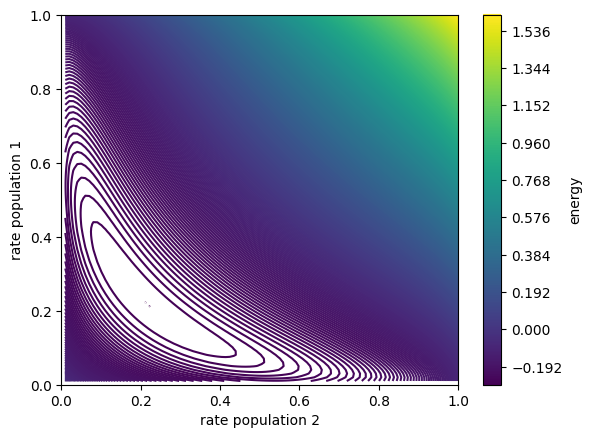

In [94]:
energy = np.zeros((100,100))

def integral(rate):
    lim = 2*rate - 1
    return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)

for i in range(100):
    r1 = i/100
    for j in range(100):
        r2 = j/100
        energy[i,j] = -0.5*(WEE - alpha)*(r1**2 + r2**2) + alpha*r1*r2 - (drive0*r1 + drive0*r2) + integral(r1) + integral(r2)

plt.contour(energy, extent=[0, 1, 0, 1], levels=500)
plt.colorbar(label='energy')
plt.xlabel('rate population 2')
plt.ylabel('rate population 1')

The energy landscape can also help us understand what happens in the model when we imbalance the inputs to the two populations. For instance, if the drive to population 2 is stronger than the drive to population 1, simulating the case in which stronger evidence is presented for stimulus 2 than for stimulus 1. This biases the competition between the two populations in favor of population 2 by making the well of population 1 much shallower, or even making it disappear:

/tmp/ipykernel_11966/4149068399.py:7: RuntimeWarning: divide by zero encountered in arctanh
  return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)
/tmp/ipykernel_11966/4149068399.py:7: RuntimeWarning: divide by zero encountered in log
  return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)
/tmp/ipykernel_11966/4149068399.py:7: RuntimeWarning: invalid value encountered in scalar add
  return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)


Text(0, 0.5, 'rate population 1')

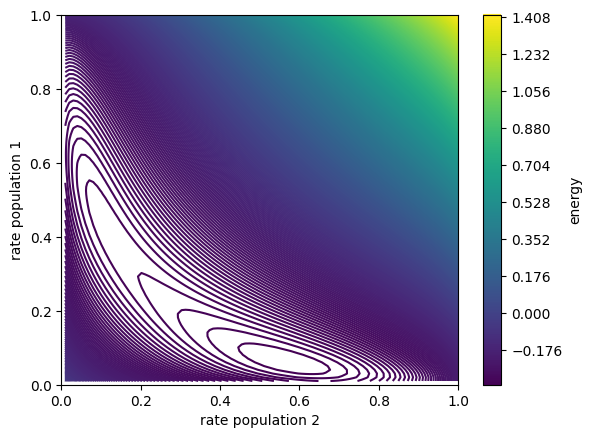

In [95]:
energy = np.zeros((100,100))
drive1 = 0.08
drive2 = 0.12

def integral(rate):
    lim = 2*rate - 1
    return 0.5*rate + 0.5* (lim*np.arctanh(lim) + 0.5*np.log(np.abs(1-lim*lim)) -0.7)

for i in range(100):
    r1 = i/100
    for j in range(100):
        r2 = j/100
        energy[i,j] = -0.5*(WEE - alpha)*(r1**2 + r2**2) + alpha*r1*r2 - (drive1*r1 + drive2*r2) + integral(r1) + integral(r2)

plt.contour(energy, extent=[0, 1, 0, 1], levels=500)
plt.colorbar(label='energy')
plt.xlabel('rate population 2')
plt.ylabel('rate population 1')

If you want to learn more about how this model has been applied to decision making, you can read [this paper](https://www.jneurosci.org/content/26/4/1314.short) by Wong and Wang.

# Ring attractor